In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mastercard-stock-data-latest-and-updated/Mastercard_stock_info.csv
/kaggle/input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

In [6]:
dataset = pd.read_csv('/kaggle/input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv', index_col = "Date",
                     parse_dates = ["Date"]).drop(['Dividends', "Stock Splits"], axis = 1)
dataset

,Open,High,Low,Close,Volume
Date,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000
2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000
...,...,...,...,...,...
2021-10-05,347.121403,348.130138,342.497241,342.776886,4724100
2021-10-06,339.580960,348.439763,338.682072,348.250000,3712000
2021-10-07,349.000000,357.899994,349.000000,353.910004,3209200


In [7]:
dataset.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

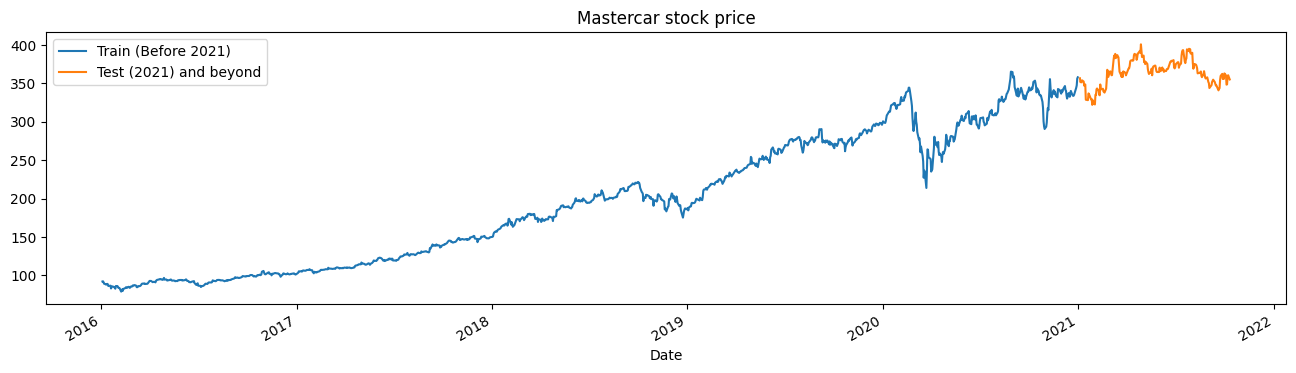

In [8]:
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize =(16,4),legend = True) 
    dataset.loc[f"{tend+1}":,  "High"].plot(figsize =(16,4),legend = True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1}) and beyond" ])
    plt.title('Mastercar stock price')
    plt.show()
train_test_plot(dataset, tstart, tend)

In [9]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":,  "High"].values
    return train, test 

In [10]:
training_set, test_set = train_test_split(dataset, tstart, tend)

In [11]:
sc = MinMaxScaler(feature_range=(0,1))
training_set = training_set.reshape(-1,1)
training_set_scaled = sc.fit_transform(training_set)

In [13]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 60
features = 1

# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [17]:
# reshaping for  model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)

In [20]:
model_lstm = Sequential()
model_lstm.add(LSTM(units = 125, activation = 'tanh', input_shape = (n_steps, features)))
model_lstm.add(Dense(units = 1))
model_lstm.compile(optimizer = 'RMSprop', loss = 'mse')
model_lstm.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 125)            │        63,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model_lstm.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0261
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0027
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0016
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0014
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0015
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0013
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 7.9373e-04
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0010
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 7.5758e-04
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 8.1996e-04
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 8.0232e-04
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 8.3505e-04
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 7.7215e-04
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 7.1306e-04
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 5

In [24]:
dataset_total = dataset.loc[:,'High']
inputs = dataset_total[len(dataset_total)-len(test_set)-n_steps :]. values
inputs = inputs.reshape(-1,1)
#scaling

inputs = sc.transform(inputs)

X_test, y_test = split_sequence(inputs, n_steps)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

predicted_stock_price = model_lstm.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


In [25]:
def plot_predictions(test, predicted):
    plt.plot(test, color = 'gray', label ='Real')
    plt.plot(predicted, color = 'red', label ='Predicted')
    plt.title('Mastercard Stock Price Prediction')
    plt.xlabel('time')
    plt.ylabel('Mastercard stock price')
    plt.legend()
    plt.show()

def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test,predicted))
    print("RSE is {:.2f}".format(rmse))

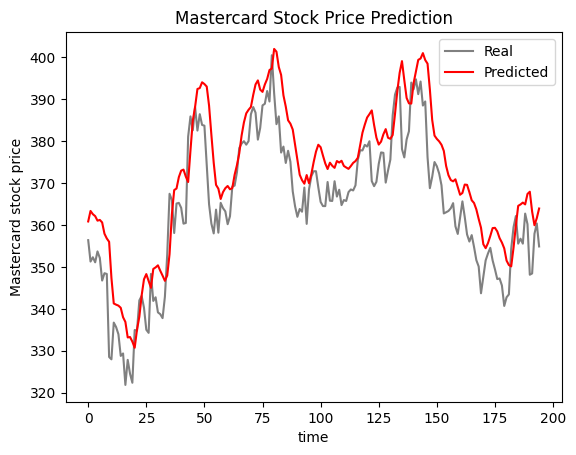

In [27]:
plot_predictions(test_set, predicted_stock_price)

In [28]:
return_rmse(test_set, predicted_stock_price)

RSE is 9.75


In [32]:
model_gru = Sequential()
model_gru.add(GRU(units = 125, activation = "tanh", input_shape=(n_steps,features)))
model_gru.add(Dense(units = 1))

model_gru.compile(optimizer = "RMSprop", loss = "mse")
model_gru.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 125)            │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,126 (187.99 KB)

 Trainable params: 48,126 (187.99 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model_gru.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0525
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0016
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0014
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 9.7477e-04
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0010    
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 8.1878e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0011
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 7.2215e-04
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 7.6826e-04
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 6.0563e-04
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 7.5165e-04
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 8.6824e-04
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 6.0630e-04
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 8.9162e-04
Epoch 15/50
38/38 ━━━━━━━━━━━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


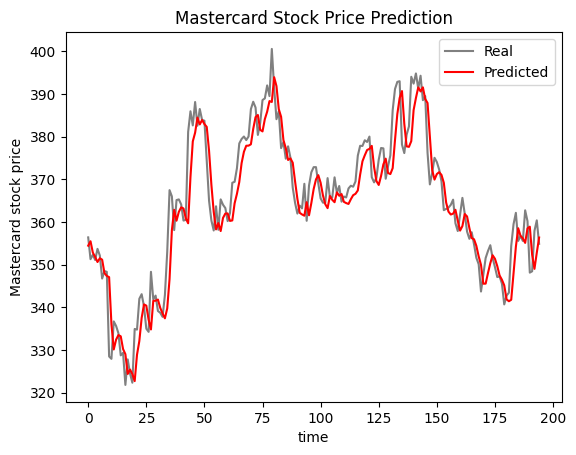

In [34]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

In [35]:
return_rmse(test_set, GRU_predicted_stock_price)

RSE is 5.98
